In [3]:
import torch
import numpy as np
import copy
import torch.nn.functional as F
import torch.nn as nn
from collections import deque
import random
import torchvision
from torchvision import models
import torchvision.transforms as T
import gym

In [4]:


class mean_val:
    def __init__(self):
        self.k = 0
        self.val = 0
        self.mean = 0

    def append(self,x):
        self.k += 1
        self.val += x
        self.mean = self.val/self.k

    def get(self):
        return self.mean


class logger:
    def __init__(self):
        self.log = dict()

    def add_log(self,name):
        self.log[name] = []

    def add_item(self,name,x):
        self.log[name].append(x)

    def get_log(self,name):
        return self.log[name]

    def get_keys(self):
        return self.log.keys()

    def get_current(self,name):
        return self.log[name][-1]

def smooth(x,window_len=11,window='hanning'):
    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y




In [3]:
class Model(nn.Module):

    def __init__(self,out_dim):
        super(Model, self).__init__()
        self.out_dim=out_dim
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.extra = nn.Sequential(
                       nn.Dropout(),
                       nn.Linear(256*6*6,4096),
                       nn.ReLU(inplace=True),
                       nn.Dropout(),
                       nn.Linear(4096,4096),
                       nn.ReLU(inplace=True))
        self.output1 = nn.Linear(4096,out_dim)
        self.output2 = nn.Linear(4096,1)

    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        x = torch.flatten(x, 1)
        y=self.extra(x)
        output1=self.output1(y)
        output2=self.output2(y)

        return output1,output2



In [5]:
class RunningMeanStd(object):

    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = torch.zeros(shape, dtype = torch.float)
        self.var = torch.ones(shape, dtype = torch.float)
        self.count = epsilon

    def update(self, x):
        batch_mean = torch.mean(x, dim=0)
        batch_var = torch.var(x, dim=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * (self.count)
        m_b = batch_var * (batch_count)
        M2 = m_a + m_b + torch.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        new_count = batch_count + self.count

        self.mean = new_mean
        self.var = new_var
        self.count = new_count


In [6]:
from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
from torch import nn
from torch.nn import functional

class Model(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [8]:
def get_states_tensor(sample, states_idx):
    sample_len = len(sample)
    states_tensor = torch.empty((sample_len, n_features), dtype=torch.float32, requires_grad=False)

    features_range = range(n_features)
    for i in range(sample_len):
        for j in features_range:
            states_tensor[i, j] = sample[i][states_idx][j].item()

    return states_tensor


In [14]:
class DQN_CNN:

    def __init__(self, env, gamma, buffer_size):
        self.env = env
        acts = env.action_space
        self.tr_1 = 1
        self.tr_2 = 1
        self.sum_tot_i=0

        obs, _ = self.env.reset()

        QNet = Model(len(obs), acts.n)
        #QNet.classifier._modules['6']=nn.Linear(4096,env.action_space.n)
        self.policy_model = QNet
        self.target_model = copy.deepcopy(self.policy_model)
        self.target_model.eval()



        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.target_model.parameters(),lr=0.00001,betas=(0.5, 0.999))
        self.batch_size = 6
        self.epsilon = 0.1
        self.buffer_size = buffer_size
        self.step_counter = 0
        self.epsi_high = 0.9
        self.epsi_low = 0.05
        self.steps = 0
        self.count = 0
        self.decay = 200
        self.delta=0.05
        self.eps = self.epsi_high
        self.update_target_step = 20
        self.log = logger()
        self.log.add_log('real_return')
        self.log.add_log('avg_loss')
        self.log.add_log('Q_reward')
        self.replay_buffer = ReplayMemory(10000)


        self.obs_rms=RunningMeanStd(shape=(1,3,224,224))

        self.eta = 0.05
        self.tem=0.1
        self.tol=1e-7
        self.discount_factor=gamma
        self.w1=2
        self.w2=1

    def run_episode(self):
        obs, _ = self.env.reset()
        acts = self.env.action_space
        sum_r = 0
        mean_loss = mean_val()
        t=0
        obs_list=[]
        Q_max = []

        done = False

        state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

        while not done:
            print(t)
            t=t+1
            self.steps += 1
            self.eps = self.epsi_low + (self.epsi_high-self.epsi_low) * (np.exp(-1.0 * self.steps/self.decay))

            #state = torch.tensor(tuple([x/255.0 for x in obs]),dtype=torch.float)
            #state = torch.transpose(state,1,2).transpose(1,0)
            #state = nn.functional.interpolate(state.unsqueeze(0),224)
            #state = T.functional.normalize(state.squeeze(0),[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]).unsqueeze(0)

            #state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)


            Q=self.policy_model(state)




            ep = torch.rand((1, )).item()
            if (ep < self.eps):
                action = torch.tensor([[random.randrange(acts.n)]], dtype=torch.long)
            else:
                with torch.no_grad():
                  action = Q.max(1)[1]
            new_state, reward, done, info, _ = self.env.step((action.item()))
            sum_r = sum_r + reward
            Q_reward = [0,0]
            Q_max.append(Q_reward)

            if done:
              new_state = None
            else:
              new_state = torch.tensor(new_state, dtype=torch.float32).unsqueeze(0)
            reward = torch.tensor([reward])
            action = torch.tensor([action], dtype=torch.long)
            self.replay_buffer.push(state,action,new_state, reward)
            loss = self.update_model()
            mean_loss.append(loss)
            state = new_state



            self.step_counter = self.step_counter + 1
            if (self.step_counter > self.update_target_step):
                self.target_model.load_state_dict(self.policy_model.state_dict())
                self.step_counter = 0
                self.target_model.eval()
                print('updated target model')
            if done:
                break


        self.log.add_item('real_return',sum_r)
        self.log.add_item('avg_loss',mean_loss.get())
        self.log.add_item('Q_reward',max(Q_reward))


    def update_model(self):
        acts = self.env.action_space
        num = len(self.replay_buffer)

        K = np.minimum(num,self.batch_size)
        samples = self.replay_buffer.sample(K)

        batch= Transition(*zip(*samples))
        S0 = torch.cat(batch.state)
        A0 = torch.cat(batch.action)
        R0 = torch.cat(batch.reward)
        #S1 = torch.cat(batch.next_state)



        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
        S1 = torch.cat([s for s in batch.next_state
                                                if s is not None])


        self.optimizer.zero_grad()
        with torch.no_grad():
          T = self.target_model(S1).max(1)[0]
        target_q = R0 + self.gamma*T
        policy_q = self.policy_model(S0).gather(1, A0.view(K, -1))
        L = F.smooth_l1_loss(policy_q,target_q.unsqueeze(1))
        L.backward()
        self.optimizer.step()

        return L.detach().item()

    def run_epoch(self):
        self.run_episode()
        return self.log





False
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
epoch: 0. return: 17.0
[17.0]
1


'\nobs = env.reset()\nfor t in range(1000):\n    env.render()\n    x = torch.Tensor(obs).unsqueeze(0)\n    Q = alg.model(x)\n    action = Q.argmax().detach().item()\n    new_obs, reward, done, info = env.step(action)\n    obs = new_obs\n    if done:\n        break\n'

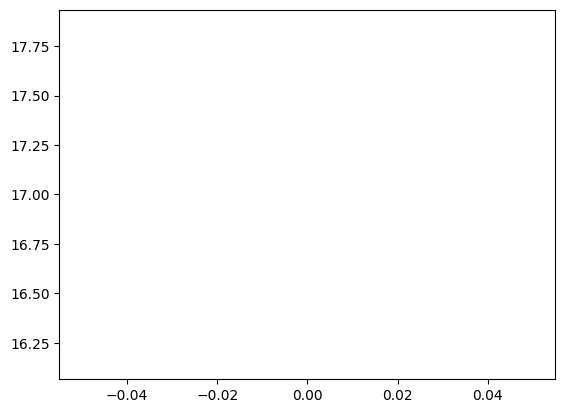

In [16]:


import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
import os



env = gym.make('CartPole-v0')



USE_CUDA = torch.cuda.is_available()


print(USE_CUDA)
if USE_CUDA:
    torch.backends.cudnn.benchmark = True


if USE_CUDA:
    os.environ['use_cuda'] = 'cuda'
else:
    os.environ['use_cuda'] = 'cpu'

def get_device():
    '''
    get_device - returns current default device.

    If Cuda is available and `os.environ['use_cuda']=='cuda'`,
    `torch.cuda.current_device()` is returned.

    Otherwise, `cpu` is returned

    Returns `torch.device`
    '''
    if torch.cuda.is_available() and os.environ['use_cuda']=='cuda':
        device = torch.cuda.current_device()
    else:
        device='cpu'

    device = torch.device(device)
    return device
gamma = 0.95
alg = DQN_CNN(env,gamma,100)
num_epochs = 1

for i in range(num_epochs):
    log = alg.run_epoch()
    print('epoch: {}. return: {}'.format(i,np.round(log.get_current('real_return')),2))
print(log.get_log('real_return'))
'''
plot the observation
'''
print(len(log.get_log('real_return')))
Y = np.asarray(log.get_log('real_return'))
#Y2 = smooth(Y)
x = np.arange(len(Y))
fig1 = plt.figure()
ax1 = plt.axes()
ax1.plot(x, Y)


# What's this step for??
"""
Give a video of the game that's played by RND+DQN
since it has the actions and observations included
"""
'''
obs = env.reset()
for t in range(1000):
    env.render()
    x = torch.Tensor(obs).unsqueeze(0)
    Q = alg.model(x)
    action = Q.argmax().detach().item()
    new_obs, reward, done, info = env.step(action)
    obs = new_obs
    if done:
        break
'''



In [18]:

#!pip install gym[atari,accept-rom-license]==0.26.0
#!pip install ale-py


import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
import os


env = gym.make('MsPacman-v0')



USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    torch.backends.cudnn.benchmark = True


if USE_CUDA:
    os.environ['use_cuda'] = 'cuda'
else:
    os.environ['use_cuda'] = 'cpu'

def get_device():
    '''
    get_device - returns current default device.

    If Cuda is available and `os.environ['use_cuda']=='cuda'`,
    `torch.cuda.current_device()` is returned.

    Otherwise, `cpu` is returned

    Returns `torch.device`
    '''
    if torch.cuda.is_available() and os.environ['use_cuda']=='cuda':
        device = torch.cuda.current_device()
    else:
        device='cpu'

    device = torch.device(device)
    return device

device = get_device()

gamma = 0.99
alg =DQN_CNN(env,gamma,100)
num_epochs = 1

for i in range(num_epochs):
    log = alg.run_epoch()
    print('epoch: {}. return: {}'.format(i,np.round(log.get_current('real_return')),2))
print(log.get_log('real_return'))
'''
plot the observation
'''
print(len(log.get_log('real_return')))
Y = np.asarray(log.get_log('real_return'))
#Y2 = smooth(Y)
x = np.arange(len(Y))
fig1 = plt.figure()
ax1 = plt.axes()
ax1.plot(x, Y)


# What's this step for??
"""
Give a video of the game that's played by RND+DQN
since it has the actions and observations included
"""
'''
obs = env.reset()
for t in range(1000):
    env.render()
    x = torch.Tensor(obs).unsqueeze(0)
    Q = alg.model(x)
    action = Q.argmax().detach().item()
    new_obs, reward, done, info = env.step(action)
    obs = new_obs
    if done:
        break
'''




0


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


RuntimeError: ignored

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True